# Tarea Galaxias, Modelado Matemático 

## Lizeth Daniela Jaimes González 

In [1]:
# Se importan las librerías que se van a utilizar 

from numpy.fft import fftshift, rfft2, irfft2
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

 Se tiene:\
    * 9 imagenes de galaxias.\
	* 9 bandas por imagen.\
	* Para cada (imagen_galaxia,banda) hay un mapa de pesos 'w_map' \
	* **Ojo**. .sci (imagenes), .wht (w_maps).\
	* Cada banda tiene una resolución distinta y un $\sigma$ asociado.

In [106]:
imagenes = './images_hubble/'

# Inicialmente, se le asocia a cada banda su sigma asociado
sigma_b = {"105":1.47,
           "125":1.49,
           "140":1.55,
           "160":1.56,
           "435":0.78,
           "606":0.95,
           "775":0.87,
           "814":0.91,
           "850":0.85 }

def direct_convolution(data,sigma,kernel_square=False):
    FWHM = sigma * (2 * np.sqrt(2 * np.log(2)))
    FWHM = np.int(FWHM)+1
    data2 = np.zeros((data.shape[0] + 2 * FWHM, data.shape[1] + 2 * FWHM))
    data2[FWHM:data.shape[0] + FWHM, FWHM:data.shape[1] + FWHM] = data
    y, x = np.indices((data2.shape))
    psf = (1. / (2 * np.pi * sigma ** 2)) * np.exp(-((x - data2.shape[1] / 2) ** 2 + (y - data2.shape[0] / 2) ** 2) / (2.0 * sigma ** 2))
    psf /= psf.sum()  # normalisation PSF
    if kernel_square:
        psf = psf**2
    psf_shift = fftshift(psf)
    data_conv = irfft2(rfft2(data2) * rfft2(psf_shift))
    data_conv = data_conv[FWHM:data.shape[0] + FWHM, FWHM:data.shape[1] + FWHM]
    return data_conv

class Galaxia ():
# Se crea la clase Galaxia con su constructor init() con los atributos:
# número de la galaxia y número de banda que queremos analizar, respectivamente.
    def __init__(self, num_galaxia, num_banda):
        self.num_galaxia = num_galaxia
        self.num_banda = num_banda        
        self.sigma = sigma_b[str(self.num_banda)]  #Se asocia el número de la banda con su respectivo sigma del diccionario 'sigma_b'
        
        print(f'Se ha escogido la galaxia {self.num_galaxia}, la banda {self.num_banda} y su respectivo sigma de {self.sigma}')

#Se crean métodos estáticos para revisar los galaxias y bandas que podemos analizar
    @staticmethod
    def galaxias_existentes():      
        return [3, 15, 37, 912, 919, 937, 943, 982, 1002]
    
    @staticmethod
    def bandas_existentes():     
        return [105, 125, 140, 160, 435, 606, 775, 814, 850]

#Después de particularizar nuestro problema a una galaxia y cierta banda con su respectivo sigma, se va generar la imagen
#Para eso se crea una subclase de Galaxia llamada Produccion_imagen y se agrega el atributo: modo
        
class Produccion_imagen(Galaxia):
#Ahora se va escoger si se quiere trabajar con las imagenes (sci) o con el mapa de peso (wht), para esto, adoptamos los atributos 
#de la clase base y en el atributo nuevo: modo, se escogerá sci o wht

    def __init__(self, num_galaxia, num_banda, modo):
        super(Produccion_imagen, self).__init__(num_galaxia, num_banda) #Aquí adoptamos los atributos de la clase Galaxia
        self.modo = modo
        
        print(f'Para la producción de la imagen se ha escogido la extensión .{self.modo}')
        
#La banda 850 está escrita de manera diferente, entonces especificamos esa diferencia en un if       
    def caso_especial(self, num_banda):
        if num_banda == 850:
            self.caso = 'lp'
        else:
            self.caso = 'w'
        
        return self.caso
    
#Ahora sí es posible generar la imagen a partir de los anteriores atributos         
    def imagen(self, num_galaxia, num_banda, modo):
        self.caso = self.caso_especial(num_banda)
        self.data = fits.open('./images_hubble/'+str(num_galaxia)+'_60mas_f'+str(num_banda)+str(self.caso_especial(num_banda))+'_'+str(modo)+'.fits')[0].data
        plt.title(f'Galaxia {self.num_galaxia} con la banda {self.num_banda}') #Así creamos el nombre del archívo que se encuentra en la carpeta 'images_hubble'
        plt.imshow(np.log10(self.data))
        return self.data
    
#Se crea un método estático para revisar los modos de imagen que podemos graficar   
    @staticmethod
    def modo_existentes():     
        return ['sci', 'wht']    
    
#Finalmente creamos una subclase que dependa de las dos clases anteriores, para crear las convoluciones y poder comparar entre imagenes
#Para eso agregamos el atributo banda2 que tiene asociado su respectivo sigma2

class Convoluciones(Produccion_imagen):
    
    def __init__(self, num_galaxia, num_banda, modo, num_banda2):
        super(Convoluciones, self).__init__(num_galaxia, num_banda, modo)  
        
    
# Función para comparar con otra banda dada en esta clase      

    def comparar(self, num_banda2):
        self.num_banda2 = num_banda2
        self.sigma2 = sigma_b[str(self.num_banda2)]
        self.sigma_t = np.sqrt(self.sigma2**2 - self.sigma**2)
        print(f'Se va comparar con la banda: {self.num_banda2} y su respectivo sigma: {self.sigma2}')
        return self.sigma_t
        
        
    def imagen_s(self, num_galaxia, num_banda, modo, num_banda2):
        self.data = self.imagen(num_galaxia, num_banda, modo)
        self.sigma_t = self.comparar(num_banda2)
        self.imagen_suavizada = direct_convolution(self.data, self.sigma_t, kernel_square=False)
        plt.title(f'Galaxia {self.num_galaxia} con el sigma total {self.sigma_t}')
        plt.imshow(np.log10(self.imagen_suavizada))
        return self.imagen_suavizada
        
# Se pasa de un mapa de pesos a uno de varianzas con el inverso     
    def varianza(self, num_galaxia, num_banda):
#        self.wht = fits.open('./images_hubble/'+str(num_galaxia)+'_60mas_f'+str(num_banda)+str(self.caso_especial(num_banda))+'_'+'wht'+'.fits')[0].data
        self.wht = self.imagen(num_galaxia, num_banda, modo = 'wht')
        self.varianza = 1. / self.wht
        return self.varianza

In [107]:
# Se escoge la instancia galaxia_1 que corresponde a la número 15 con la banda 125
galaxia_1 = Galaxia(15, 125)

Se ha escogido la galaxia 15, la banda 125 y su respectivo sigma de 1.49


In [108]:
#Se verifica el sigma correspondiente a esa banda
galaxia_1.sigma

1.49

In [109]:
#Se revisan las galaxias y bandas existentes
galaxia_1.galaxias_existentes()

[3, 15, 37, 912, 919, 937, 943, 982, 1002]

In [110]:
galaxia_1.bandas_existentes()

[105, 125, 140, 160, 435, 606, 775, 814, 850]

In [111]:
#Ahora se crea la instancia galaxia_2 para producir una imagen, es decir, se escoge como parte de la subclase Produccion_imagen
galaxia_2 = Produccion_imagen(15, 125, 'sci')

Se ha escogido la galaxia 15, la banda 125 y su respectivo sigma de 1.49
Para la producción de la imagen se ha escogido la extensión .sci


In [112]:
#Se revisan los modos existentes 
galaxia_2.modo_existentes()

['sci', 'wht']

In [113]:
#Se puede revisar la extensión de la banda
galaxia_2.caso_especial(125)

'w'

<ipython-input-106-bf8627b99053>:75: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(self.data))


array([[-3.6431456e-04,  4.4940689e-04,  6.6707187e-05, ...,
        -3.0167185e-04, -8.7320904e-04, -2.8893779e-04],
       [-6.3486921e-04,  7.4182637e-04,  5.7547324e-04, ...,
        -3.8373462e-04, -6.4804823e-05, -8.1975403e-04],
       [ 1.4955977e-04,  1.0139348e-05, -5.2716161e-05, ...,
        -1.8811450e-04,  4.6024515e-04, -2.1471090e-04],
       ...,
       [-1.0625913e-03, -1.0277450e-03, -3.1604859e-04, ...,
        -2.3822188e-04,  6.5806927e-04,  9.9435158e-04],
       [-4.9008522e-04, -4.2365474e-04, -1.2237749e-04, ...,
        -1.9619618e-04,  1.0594127e-03,  7.8709610e-04],
       [-7.2371331e-05,  4.6726345e-04,  1.0519149e-03, ...,
        -3.5834042e-04,  5.7565724e-04,  4.2979504e-04]], dtype=float32)

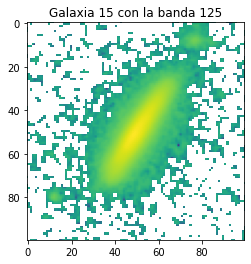

In [114]:
#Graficamos la galaxia_2 que corresponde a la número 15 con la banda 125 y el modo 'sci'
galaxia_2.imagen(15, 125, 'sci')

In [115]:
#Se crea una galaxia 3 para el estudio de la subclase Convoluciones
galaxia_3 = Convoluciones(15, 125, 'sci', 140)

Se ha escogido la galaxia 15, la banda 125 y su respectivo sigma de 1.49
Para la producción de la imagen se ha escogido la extensión .sci


<ipython-input-106-bf8627b99053>:75: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(self.data))


array([[-3.6431456e-04,  4.4940689e-04,  6.6707187e-05, ...,
        -3.0167185e-04, -8.7320904e-04, -2.8893779e-04],
       [-6.3486921e-04,  7.4182637e-04,  5.7547324e-04, ...,
        -3.8373462e-04, -6.4804823e-05, -8.1975403e-04],
       [ 1.4955977e-04,  1.0139348e-05, -5.2716161e-05, ...,
        -1.8811450e-04,  4.6024515e-04, -2.1471090e-04],
       ...,
       [-1.0625913e-03, -1.0277450e-03, -3.1604859e-04, ...,
        -2.3822188e-04,  6.5806927e-04,  9.9435158e-04],
       [-4.9008522e-04, -4.2365474e-04, -1.2237749e-04, ...,
        -1.9619618e-04,  1.0594127e-03,  7.8709610e-04],
       [-7.2371331e-05,  4.6726345e-04,  1.0519149e-03, ...,
        -3.5834042e-04,  5.7565724e-04,  4.2979504e-04]], dtype=float32)

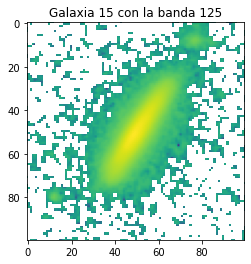

In [120]:
#Se genera la imagen que es exactamente igual a la anterior parar probar que Convoluciones es una subclase de la clase Produccion_imagen
galaxia_3.imagen(15, 125, 'sci')

In [117]:
#Se escoge la banda con la que se quiere comparar
galaxia_3.comparar(140)

Se va comparar con la banda: 140 y su respectivo sigma: 1.55


0.42708313008125287

Se va comparar con la banda: 140 y su respectivo sigma: 1.55


<ipython-input-106-bf8627b99053>:75: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(self.data))
<ipython-input-106-bf8627b99053>:107: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(self.imagen_suavizada))


array([[-2.92768240e-04,  3.74839007e-04,  8.04957267e-05, ...,
        -2.87236200e-04, -7.22119758e-04, -3.12547115e-04],
       [-4.69874852e-04,  6.01557138e-04,  4.76479745e-04, ...,
        -3.32892875e-04, -1.35871140e-04, -6.73213881e-04],
       [ 1.37714085e-04,  4.94145403e-05, -3.98353781e-07, ...,
        -2.42279190e-04,  3.10555823e-04, -1.65136469e-04],
       ...,
       [-9.76375365e-04, -9.50050981e-04, -3.44188793e-04, ...,
        -1.96822310e-04,  6.19082937e-04,  9.05003770e-04],
       [-4.65181177e-04, -3.93026406e-04, -9.98884081e-05, ...,
        -1.71669185e-04,  9.26126972e-04,  7.47174222e-04],
       [-5.93142491e-05,  3.92690444e-04,  8.63264174e-04, ...,
        -2.89935394e-04,  5.10753870e-04,  4.09591945e-04]])

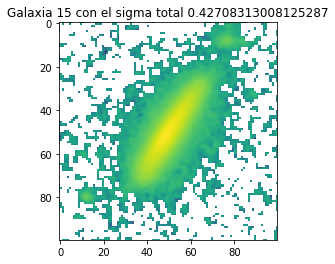

In [118]:
#Se grafica la imagen suavizada
galaxia_3.imagen_s(15, 125, 'sci', 140)

array([[1.7625548e-06, 1.9443439e-06, 1.8846060e-06, ..., 1.7254571e-06,
        1.7803521e-06, 1.8366791e-06],
       [1.8308865e-06, 1.7734255e-06, 1.7493196e-06, ..., 1.7734017e-06,
        1.7801943e-06, 1.6982469e-06],
       [1.8535516e-06, 1.7169825e-06, 1.7659406e-06, ..., 1.8103412e-06,
        1.7155452e-06, 1.7496541e-06],
       ...,
       [1.8171471e-06, 1.8848207e-06, 1.8974591e-06, ..., 1.7982891e-06,
        1.9009263e-06, 1.7504053e-06],
       [1.7598700e-06, 1.8025157e-06, 1.8641865e-06, ..., 1.8169375e-06,
        1.9261047e-06, 1.8507823e-06],
       [1.7630706e-06, 1.7350163e-06, 1.8612490e-06, ..., 1.8894596e-06,
        1.7697588e-06, 1.9220092e-06]], dtype=float32)

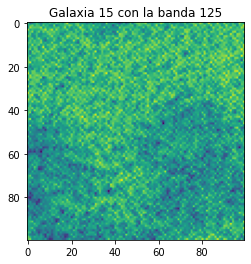

In [119]:
#Se revisa la varianza
galaxia_3.varianza(15, 125)